In [1]:
import os
import sys

import pandas as pd
import xarray as xr

import FINE as fn
from FINE.spagat.RE_representation import represent_RE_technology

cwd = os.getcwd()

%load_ext autoreload
%autoreload 2

# Workflow for spatial aggregation of an energy system model

This example notebook shows how model regions can be merged to obtain fewer regions and also how the number of VRES within each region can be reduced to fewer types. 

<img src="spagat_basic_depiction.png" style="width: 1000px;"/>

The figure above dipicts the basic idea behind spatial aggregation. The term spatial grouping refers to grouping (and subsequently merging) of regions that are similar in some sense (NOTE: Please look into the documentation for different methods to group regions). 

Additionally, it is also possible to reduce each VRES within each region to a desired number. This process is called spatial representation of VRES. To give you an example, if the results of your PV simulation are spatially detailed or spatially highly resolved, then you could reduce these to a few types within each region. The time series profiles are matched during grouping of these technologies. 


## STEP 1. Set up your ESM instance 

In [2]:
from getModel import getModel

esM = getModel()

The distances of a component are set to a normalized value of 1.


 c:\users\s.patil\documents\code\fine\FINE\utils.py:982: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.


In [3]:
esM.locations

{'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7'}

## STEP 2. Spatial grouping of regions

In [4]:
# The input data to spatial grouping are esM instance and the shapefile containing model regions' geometries
SHAPEFILE_PATH = os.path.join(
    cwd,
    "..",
    "Multi-regional_Energy_System_Workflow/InputData/SpatialData/ShapeFiles/clusteredRegions.shp",
)

In [5]:
# Once the regions are grouped, the data witin each region group needs to be aggregated. Through the aggregation_function_dict
# parameter, it is possible to define how each variable show be aggregated. Please refer to the documentation for more
# information.

aggregation_function_dict = {
    "operationRateMax": ("mean", "capacityMax"),
    "operationRateFix": ("sum", None),
    "locationalEligibility": ("bool", None),
    "capacityMax": ("sum", None),
    "investPerCapacity": ("sum", None),
    "investIfBuilt": ("sum", None),
    "opexPerOperation": ("sum", None),
    "opexPerCapacity": ("sum", None),
    "opexIfBuilt": ("sum", None),
    "interestRate": ("mean", None),
    "economicLifetime": ("mean", None),
    "capacityFix": ("sum", None),
    "losses": ("mean", None),
    "distances": ("mean", None),
    "commodityCost": ("mean", None),
    "commodityRevenue": ("mean", None),
    "opexPerChargeOperation": ("mean", None),
    "opexPerDischargeOperation": ("mean", None),
    "QPcostScale": ("sum", None),
    "technicalLifetime": ("sum", None),
}

In [6]:
# You can provide a path to save the grouping results with desired file names. Two files are saved - a shapefile containing
# the merged region geometries and a netcdf file containing the aggregated esM instance data.
shp_name = "aggregated_regions"
aggregated_xr_filename = "aggregated_xr_ds.nc4"

In [7]:
# Spatial grouping
aggregated_esM = esM.aggregateSpatially(
    shapefile=SHAPEFILE_PATH,
    grouping_mode="parameter_based",
    n_groups=4,
    aggregatedResultsPath=os.path.join(cwd, "output_data"),
    aggregation_function_dict=aggregation_function_dict,
    shp_name=shp_name,
    aggregated_xr_filename=aggregated_xr_filename,
    solver="glpk",
)


0 iteration: Solving instance
Total distance: 2206.1745574830743 with solving time: 0.14096546173095703
2 contiguity constraints/cuts added, adding to a total number of 2 cuts within time: 0.0020232200622558594
1 iteration: Solving instance
Total distance: 2768.891596034753 with solving time: 0.10928082466125488
6 contiguity constraints/cuts added, adding to a total number of 8 cuts within time: 0.009017467498779297
2 iteration: Solving instance
Total distance: 3211.3848670198327 with solving time: 0.10059976577758789
0 contiguity constraints/cuts added, adding to a total number of 8 cuts within time: 0.0010001659393310547
elapsed time for perform_parameter_based_grouping: 0.07 minutes


 C:\Users\s.patil\Anaconda3\envs\fine_dev\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


elapsed time for perform_spatial_aggregation: 0.20 minutes


 c:\users\s.patil\documents\code\fine\FINE\utils.py:982: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.


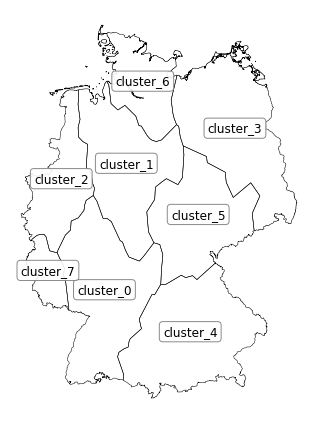

In [8]:
# Original spatial resolution
fig, ax = fn.plotLocations(SHAPEFILE_PATH, plotLocNames=True, indexColumn="index")

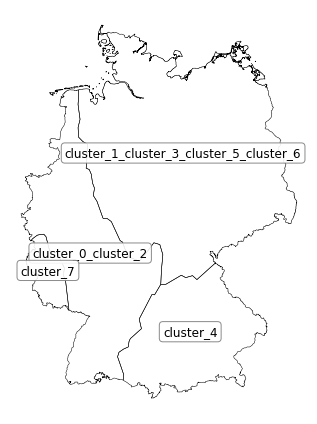

In [9]:
# Spatial resolution after aggregation
AGGREGATED_SHP_PATH = os.path.join(cwd, "output_data", f"{shp_name}.shp")

fig, ax = fn.plotLocations(AGGREGATED_SHP_PATH, plotLocNames=True, indexColumn="space")

In [10]:
# The locations in the resulting esM instance are now 4.
aggregated_esM.locations

{'cluster_0_cluster_2',
 'cluster_1_cluster_3_cluster_5_cluster_6',
 'cluster_4',
 'cluster_7'}

In [11]:
#  And corresponding data has also been aggregated
aggregated_esM.getComponentAttribute("Wind (onshore)", "operationRateMax")

space  cluster_0_cluster_2  cluster_1_cluster_3_cluster_5_cluster_6  \
time                                                                  
0                 0.778801                                 0.896089   
1                 0.779175                                 0.889352   
2                 0.772609                                 0.875346   
3                 0.762311                                 0.851198   
4                 0.740985                                 0.824188   
...                    ...                                      ...   
8755              0.535852                                 0.515689   
8756              0.510271                                 0.474827   
8757              0.530000                                 0.432508   
8758              0.529114                                 0.393702   
8759              0.480871                                 0.386609   

space  cluster_4  cluster_7  
time                         
0       0.276660   0.623974  
1       0.275148   0.667338  
2       0.286690   0.696272  
3       0.303492   0.705269  
4       0.324501   0.710336  
...          ...        ...  
8755    0.155183   0.426975  
8756    0.119844   0.429161  
8757    0.101342   0.507018  
8758    0.093761   0.396641  
8759    0.101512   0.313036  

[8760 rows x 4 columns]

# STEP 3. Spatial Representation of VRES (Optional)

### STEP 3a. Spatial representation

In [12]:
# The input data to spatial representation are a netcdf file containing highly resolved VRES data
# and the shapefile containing model regions' geometries

# Here, both PV and wind turbines are represented

ONSHORE_WIND_DATA_PATH = os.path.join(
    cwd, "input_RE_representation_data", "DEU_wind.nc4"
)
PV_DATA_PATH = os.path.join(cwd, "input_RE_representation_data", "DEU_pv.nc4")

In [13]:
# Let us first take a look at one of these datasets

xr.open_dataset(ONSHORE_WIND_DATA_PATH)

<xarray.Dataset>
Dimensions:      (time: 8760, x: 88, y: 117)
Coordinates:
  * y            (y) float64 2.832e+06 2.838e+06 ... 3.408e+06 3.412e+06
  * x            (x) float64 4.092e+06 4.098e+06 ... 4.522e+06 4.528e+06
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    capacity     (y, x) float64 ...
    capfac       (time, y, x) float32 ...
Attributes:
    xy_reference_system:  EPSG:3035
    grid_mapping:         spatial_ref

In [14]:
## Representation
represented_wind_ds = represent_RE_technology(
    ONSHORE_WIND_DATA_PATH,
    "xy_reference_system",
    AGGREGATED_SHP_PATH,
    n_timeSeries_perRegion=5,
    capacity_var_name="capacity",
    capfac_var_name="capfac",
    index_col="space",
)

represented_pv_ds = represent_RE_technology(
    PV_DATA_PATH,
    "xy_reference_system",
    AGGREGATED_SHP_PATH,
    n_timeSeries_perRegion=5,
    capacity_var_name="capacity",
    capfac_var_name="capfac",
    index_col="space",
)

elapsed time for represent_RE_technology: 2.93 minutes
elapsed time for represent_RE_technology: 2.89 minutes


In [15]:
represented_wind_ds

<xarray.Dataset>
Dimensions:     (TS_ids: 5, region_ids: 4, time: 8760)
Coordinates:
  * region_ids  (region_ids) object 'cluster_0_cluster_2' ... 'cluster_7'
  * TS_ids      (TS_ids) <U4 'TS_0' 'TS_1' 'TS_2' 'TS_3' 'TS_4'
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    capacity    (region_ids, TS_ids) float64 6.236e+04 2.296e+04 ... 2.296e+04
    capfac      (time, region_ids, TS_ids) float64 0.384 0.7 0.5018 ... 0.2 0.7

In [16]:
represented_pv_ds

<xarray.Dataset>
Dimensions:     (TS_ids: 5, region_ids: 4, time: 8760)
Coordinates:
  * region_ids  (region_ids) object 'cluster_0_cluster_2' ... 'cluster_7'
  * TS_ids      (TS_ids) <U4 'TS_0' 'TS_1' 'TS_2' 'TS_3' 'TS_4'
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:00:00
Data variables:
    capacity    (region_ids, TS_ids) float64 4.03e+07 3.592e+04 ... 1.746e+04
    capfac      (time, region_ids, TS_ids) float64 0.1992 0.1361 0.1 ... 0.2 0.3

### STEP 3a. Adding the results to esM instance 

In [17]:
# Now we need to delete 'Wind (onshore)' and 'PV' compoents from aggregated_esM
# and add the represented results

In [18]:
## But first we need certain info corresponding to these techs as they remain the same:
var_list = ["investPerCapacity", "opexPerCapacity", "interestRate", "economicLifetime"]

wind_vars = {}
pv_vars = {}

for var in var_list:
    wind_vars.update({var: aggregated_esM.getComponentAttribute("Wind (onshore)", var).mean()})
    pv_vars.update({var: aggregated_esM.getComponentAttribute("PV", var).mean()})

In [19]:
## And now we delete them
aggregated_esM.removeComponent("Wind (onshore)")
aggregated_esM.removeComponent("PV")

In [20]:
aggregated_esM.componentModelingDict["SourceSinkModel"].componentsDict

{'Electricity demand': <FINE.sourceSink.Sink at 0x1aafe428828>,
 'Hydrogen demand': <FINE.sourceSink.Sink at 0x1aafe428cf8>}

In [21]:
## Prepare the representation results and add them to aggregated_esM
data = {}

time_steps = aggregated_esM.totalTimeSteps
regions = represented_wind_ds["region_ids"].values
clusters = represented_wind_ds["TS_ids"].values  # technology types per region


for i, cluster in enumerate(clusters):
    # Add a wind turbine
    data.update(
        {
            f"Wind (onshore), capacityMax {i}": pd.Series(
                represented_wind_ds.capacity.loc[:, cluster], index=regions
            )
        }
    )

    data.update(
        {
            f"Wind (onshore), operationRateMax {i}": pd.DataFrame(
                represented_wind_ds.capfac.loc[:, :, cluster].values,
                index=time_steps,
                columns=regions,
            )
        }
    )

    # Add a pv
    data.update(
        {
            f"PV, capacityMax {i}": pd.Series(
                represented_pv_ds.capacity.loc[:, cluster], index=regions
            )
        }
    )

    data.update(
        {
            f"PV, operationRateMax {i}": pd.DataFrame(
                represented_pv_ds.capfac.loc[:, :, cluster].values,
                index=time_steps,
                columns=regions,
            )
        }
    )

In [22]:
## add the data
for i, cluster in enumerate(clusters):
    aggregated_esM.add(
        fn.Source(
            esM=aggregated_esM,
            name=f"Wind (onshore) {i}",
            commodity="electricity",
            hasCapacityVariable=True,
            operationRateMax=data[f"Wind (onshore), operationRateMax {i}"],
            capacityMax=data[f"Wind (onshore), capacityMax {i}"],
            investPerCapacity=wind_vars.get("investPerCapacity"),
            opexPerCapacity=wind_vars.get("opexPerCapacity"),
            interestRate=wind_vars.get("interestRate"),
            economicLifetime=wind_vars.get("economicLifetime"),
        )
    )

    aggregated_esM.add(
        fn.Source(
            esM=aggregated_esM,
            name=f"PV {i}",
            commodity="electricity",
            hasCapacityVariable=True,
            operationRateMax=data[f"PV, operationRateMax {i}"],
            capacityMax=data[f"PV, capacityMax {i}"],
            investPerCapacity=pv_vars.get("investPerCapacity"),
            opexPerCapacity=pv_vars.get("opexPerCapacity"),
            interestRate=pv_vars.get("interestRate"),
            economicLifetime=pv_vars.get("economicLifetime"),
        )
    )

In [23]:
aggregated_esM.componentModelingDict["SourceSinkModel"].componentsDict

{'Electricity demand': <FINE.sourceSink.Sink at 0x1aafe428828>,
 'Hydrogen demand': <FINE.sourceSink.Sink at 0x1aafe428cf8>,
 'Wind (onshore) 0': <FINE.sourceSink.Source at 0x1aafe428240>,
 'PV 0': <FINE.sourceSink.Source at 0x1aafcc7a208>,
 'Wind (onshore) 1': <FINE.sourceSink.Source at 0x1aafcaf40f0>,
 'PV 1': <FINE.sourceSink.Source at 0x1aafcaf49b0>,
 'Wind (onshore) 2': <FINE.sourceSink.Source at 0x1aafcaea2e8>,
 'PV 2': <FINE.sourceSink.Source at 0x1aafcaeaba8>,
 'Wind (onshore) 3': <FINE.sourceSink.Source at 0x1aafcaf14e0>,
 'PV 3': <FINE.sourceSink.Source at 0x1aafcaf1da0>,
 'Wind (onshore) 4': <FINE.sourceSink.Source at 0x1aafcad96d8>,
 'PV 4': <FINE.sourceSink.Source at 0x1aafcad9f98>}

# Step 4. Temporal Aggregation

Although spatial aggregation aids in reducing the computational complexity of optimization, temporal aggregation is still necessary. 

Spatial aggregation is not here is replace temporal aggregation. They both go hand-in-hand. 

Imagine performing temporal aggregation on a model with too many regions and too many VRES technologies per region. You have to reduce the temporal resolution to a large extent. Or you can take too few regions and 1 time series per VRES technology, per region and reduce the temporal resolution to a smaller extent. 

With spatial and temporal aggregation, you need not compromise on either the temporal or spatial resolution of your model. 

In [24]:
aggregated_esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...


 c:\users\s.patil\documents\code\tsam\tsam\timeseriesaggregation.py:733: UserWarning:Max iteration number reached for "PV 2_operationRate_cluster_0_cluster_2" while rescaling the cluster periods. The integral of the aggregated time series deviates by: 0.0%
 c:\users\s.patil\documents\code\tsam\tsam\timeseriesaggregation.py:733: UserWarning:Max iteration number reached for "PV 2_operationRate_cluster_1_cluster_3_cluster_5_cluster_6" while rescaling the cluster periods. The integral of the aggregated time series deviates by: 0.0%
 c:\users\s.patil\documents\code\tsam\tsam\timeseriesaggregation.py:733: UserWarning:Max iteration number reached for "PV 2_operationRate_cluster_4" while rescaling the cluster periods. The integral of the aggregated time series deviates by: 0.0%
 c:\users\s.patil\documents\code\tsam\tsam\timeseriesaggregation.py:733: UserWarning:Max iteration number reached for "PV 3_operationRate_cluster_0_cluster_2" while rescaling the cluster periods. The integral of the agg

		(2.5005 sec)



# Step 5. Optimization

In [25]:
aggregated_esM.optimize(timeSeriesAggregation=True)
# The following `optimizationSpecs` are recommended if you use the Gurobi solver.
# aggregated_esM.optimize(timeSeriesAggregation=True,
#                         optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7713 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1541 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5856 sec)

Declaring sets, variables and constraints for LOPFModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1157 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0846 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances.

 c:\users\s.patil\documents\code\fine\FINE\storage.py:1759: UserWarning:Charge and discharge at the same time for component Li-ion batteries


for StorageModel ...       (1.7913sec)
for LOPFModel ...          (1.2693sec)
for TransmissionModel ...  (1.2259sec)
		(6.0135 sec)

